<a href="https://colab.research.google.com/github/flydragon2018/colab_notebooks/blob/main/colab_yolox_reef_cots_demo_1228.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Dec 30 15:45:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   2359MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive', force_remount=True)

Mounted at /content/mydrive


In [ ]:
#!pip -q install fsspec
#!pip -q  install gcsfs

In [ ]:
#import gcsfs
#fs = gcsfs.GCSFileSystem()

In [ ]:
##!gsutil -m cp -r  gs://kds-87f39ccfe721b0f0b4087508aefd658220bc65ce44e62df765a13734/  /content/mydrive/MyDrive/kaggle/

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import ast
import os
import json
import pandas as pd
import torch
import importlib
import cv2 

from shutil import copyfile
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupKFold
from PIL import Image
from string import Template
from IPython.display import display


In [ ]:

TRAIN_PATH = '/content/mydrive/MyDrive/kaggle/reef'

In [ ]:
# check Torch and CUDA version
print(f"Torch: {torch.__version__}")
!nvcc --version

Torch: 1.10.0+cu111
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!git clone https://github.com/Megvii-BaseDetection/YOLOX -q

%cd YOLOX
!pip install -U pip && pip install -r requirements.txt
!pip install -v -e . 

/content/YOLOX/YOLOX
Using pip 21.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Obtaining file:///content/YOLOX/YOLOX
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-ig9hgb1j/yolox.egg-info
  writing /tmp/pip-pip-egg-info-ig9hgb1j/yolox.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-ig9hgb1j/yolox.egg-info/dependency_links.txt
  writing top-level names to /tmp/pip-pip-egg-info-ig9hgb1j/yolox.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-ig9hgb1j/yolox.egg-info/SOURCES.txt'
  adding license file 'LICENSE'
  writing manifest file '/tmp/pip-pip-egg-info-ig9hgb1j/yolox.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
  Attempting uninstall: yolox
    Found existing installation: yolox 0.1.0
    Can't uninstall 'yolox'. No files were found to uninstall.
  Running setup.py develop for yolox
    Running command /usr/bin/python3 -c 'import io, os, sys, setuptools, toke

In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [ ]:
df = pd.read_csv("/content/mydrive/MyDrive/kaggle/reef/train.csv")
df.head(5)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


In [ ]:
# Taken only annotated photos
df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))
df_train = df[df["num_bbox"]>0]

#Annotations 
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)

#Images resolution
df_train["width"] = 1280
df_train["height"] = 720

#Path of images
df_train = df_train.progress_apply(get_path, axis=1)

  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

In [ ]:
kf = GroupKFold(n_splits = 5) 
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
    df_train.loc[val_idx, 'fold'] = fold

df_train.head(5)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bbox,bboxes,width,height,image_path,fold
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1,"[[559, 213, 50, 32]]",1280,720,/content/mydrive/MyDrive/kaggle/reef/train_ima...,4
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1,"[[558, 213, 50, 32]]",1280,720,/content/mydrive/MyDrive/kaggle/reef/train_ima...,4
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1,"[[557, 213, 50, 32]]",1280,720,/content/mydrive/MyDrive/kaggle/reef/train_ima...,4
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1,"[[556, 214, 50, 32]]",1280,720,/content/mydrive/MyDrive/kaggle/reef/train_ima...,4
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1,"[[555, 214, 50, 32]]",1280,720,/content/mydrive/MyDrive/kaggle/reef/train_ima...,4


In [ ]:
HOME_DIR = '/content/mydrive/MyDrive/kaggle/reefdata/' 

In [ ]:


'''
for i in range(5):
  SELECTED_FOLD=i
  DATASET_PATH = 'dataset{}/images'.format(SELECTED_FOLD)

  #!mkdir {HOME_DIR}dataset
  !mkdir -p {HOME_DIR}{DATASET_PATH}
  !mkdir -p {HOME_DIR}{DATASET_PATH}/train2017
  !mkdir -p {HOME_DIR}{DATASET_PATH}/val2017
  !mkdir -p {HOME_DIR}{DATASET_PATH}/annotations
  for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    if row.fold != SELECTED_FOLD:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train2017/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val2017/{row.image_id}.jpg') 
'''

"\nfor i in range(5):\n  SELECTED_FOLD=i\n  DATASET_PATH = 'dataset{}/images'.format(SELECTED_FOLD)\n\n  #!mkdir {HOME_DIR}dataset\n  !mkdir -p {HOME_DIR}{DATASET_PATH}\n  !mkdir -p {HOME_DIR}{DATASET_PATH}/train2017\n  !mkdir -p {HOME_DIR}{DATASET_PATH}/val2017\n  !mkdir -p {HOME_DIR}{DATASET_PATH}/annotations\n  for i in tqdm(range(len(df_train))):\n    row = df_train.loc[i]\n    if row.fold != SELECTED_FOLD:\n        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train2017/{row.image_id}.jpg')\n    else:\n        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val2017/{row.image_id}.jpg') \n"

In [ ]:
#SELECTED_FOLD = 4

In [ ]:
  SELECTED_FOLD = 4

  DATASET_PATH = 'dataset{}/images'.format(SELECTED_FOLD)

'''
  #!mkdir {HOME_DIR}dataset
  !mkdir -p {HOME_DIR}{DATASET_PATH}
  !mkdir -p {HOME_DIR}{DATASET_PATH}/train2017
  !mkdir -p {HOME_DIR}{DATASET_PATH}/val2017
  !mkdir -p {HOME_DIR}{DATASET_PATH}/annotations
  for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    if row.fold != SELECTED_FOLD:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train2017/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val2017/{row.image_id}.jpg') 
'''

"\n#!mkdir {HOME_DIR}dataset\n!mkdir -p {HOME_DIR}{DATASET_PATH}\n!mkdir -p {HOME_DIR}{DATASET_PATH}/train2017\n!mkdir -p {HOME_DIR}{DATASET_PATH}/val2017\n!mkdir -p {HOME_DIR}{DATASET_PATH}/annotations\nfor i in tqdm(range(len(df_train))):\n  row = df_train.loc[i]\n  if row.fold != SELECTED_FOLD:\n      copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train2017/{row.image_id}.jpg')\n  else:\n      copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val2017/{row.image_id}.jpg') \n"

In [ ]:

'''
for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    if row.fold != SELECTED_FOLD:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train2017/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val2017/{row.image_id}.jpg') 
'''

"\nfor i in tqdm(range(len(df_train))):\n    row = df_train.loc[i]\n    if row.fold != SELECTED_FOLD:\n        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train2017/{row.image_id}.jpg')\n    else:\n        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val2017/{row.image_id}.jpg') \n"

In [ ]:
print(f'Number of training files: {len(os.listdir(f"{HOME_DIR}{DATASET_PATH}/train2017/"))}')
print(f'Number of validation files: {len(os.listdir(f"{HOME_DIR}{DATASET_PATH}/val2017/"))}')

Number of training files: 3974
Number of validation files: 945


In [ ]:
def save_annot_json(json_annotation, filename):
    with open(filename, 'w') as f:
        output_json = json.dumps(json_annotation)
        f.write(output_json)

In [ ]:
annotion_id = 0

In [ ]:
def dataset2coco(df, dest_path):
    
    global annotion_id
    
    annotations_json = {
        "info": [],
        "licenses": [],
        "categories": [],
        "images": [],
        "annotations": []
    }
    
    info = {
        "year": "2021",
        "version": "1",
        "description": "COTS dataset - COCO format",
        "contributor": "",
        "url": "https://kaggle.com",
        "date_created": "2021-11-30T15:01:26+00:00"
    }
    annotations_json["info"].append(info)
    
    lic = {
            "id": 1,
            "url": "",
            "name": "Unknown"
        }
    annotations_json["licenses"].append(lic)

    classes = {"id": 0, "name": "starfish", "supercategory": "none"}

    annotations_json["categories"].append(classes)

    
    for ann_row in df.itertuples():
            
        images = {
            "id": ann_row[0],
            "license": 1,
            "file_name": ann_row.image_id + '.jpg',
            "height": ann_row.height,
            "width": ann_row.width,
            "date_captured": "2021-11-30T15:01:26+00:00"
        }
        
        annotations_json["images"].append(images)
        
        bbox_list = ann_row.bboxes
        
        for bbox in bbox_list:
            b_width = bbox[2]
            b_height = bbox[3]
            
            # some boxes in COTS are outside the image height and width
            if (bbox[0] + bbox[2] > 1280):
                b_width = 1280-bbox[0] 
            if (bbox[1] + bbox[3] > 720):
                b_height = 720 -bbox[1]
                
            image_annotations = {
                "id": annotion_id,
                "image_id": ann_row[0],
                "category_id": 0,
                "bbox": [bbox[0], bbox[1], b_width, b_height],
                "area": bbox[2] * bbox[3],
                "segmentation": [],
                "iscrowd": 0
            }
            
            annotion_id += 1
            annotations_json["annotations"].append(image_annotations)
        
        
    print(f"Dataset COTS annotation to COCO json format completed! Files: {len(df)}")
    return annotations_json


In [ ]:
# Convert COTS dataset to JSON COCO
'''
for i in range(5):
  SELECTED_FOLD=i
  train_annot_json = dataset2coco(df_train[df_train.fold != SELECTED_FOLD], f"{HOME_DIR}{DATASET_PATH}/train2017/")
  val_annot_json = dataset2coco(df_train[df_train.fold == SELECTED_FOLD], f"{HOME_DIR}{DATASET_PATH}/val2017/")

  # Save converted annotations
  save_annot_json(train_annot_json, f"{HOME_DIR}{DATASET_PATH}/annotations/train.json")
  save_annot_json(val_annot_json, f"{HOME_DIR}{DATASET_PATH}/annotations/valid.json")

'''

'\nfor i in range(5):\n  SELECTED_FOLD=i\n  train_annot_json = dataset2coco(df_train[df_train.fold != SELECTED_FOLD], f"{HOME_DIR}{DATASET_PATH}/train2017/")\n  val_annot_json = dataset2coco(df_train[df_train.fold == SELECTED_FOLD], f"{HOME_DIR}{DATASET_PATH}/val2017/")\n\n  # Save converted annotations\n  save_annot_json(train_annot_json, f"{HOME_DIR}{DATASET_PATH}/annotations/train.json")\n  save_annot_json(val_annot_json, f"{HOME_DIR}{DATASET_PATH}/annotations/valid.json")\n\n'

In [ ]:

# Convert COTS dataset to JSON COCO
train_annot_json = dataset2coco(df_train[df_train.fold != SELECTED_FOLD], f"{HOME_DIR}{DATASET_PATH}/train2017/")
val_annot_json = dataset2coco(df_train[df_train.fold == SELECTED_FOLD], f"{HOME_DIR}{DATASET_PATH}/val2017/")

# Save converted annotations
save_annot_json(train_annot_json, f"{HOME_DIR}{DATASET_PATH}/annotations/train.json")
save_annot_json(val_annot_json, f"{HOME_DIR}{DATASET_PATH}/annotations/valid.json")



Dataset COTS annotation to COCO json format completed! Files: 3974
Dataset COTS annotation to COCO json format completed! Files: 945


In [ ]:
config_file_template = '''

#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# Copyright (c) Megvii, Inc. and its affiliates.

import os

from yolox.exp import Exp as MyExp

SELECTED_FOLD =4

class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        #self.depth = 0.33
        #self.width = 0.50
        self.depth = 1.00
        self.width = 1.00
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]
        
        # Define yourself dataset path
        #self.data_dir = "/kaggle/working/dataset/images"
        self.data_dir = "/content/mydrive/MyDrive/kaggle/reefdata/dataset{}/images".format(SELECTED_FOLD)
        self.train_ann = "train.json"
        self.val_ann = "valid.json"

        self.num_classes = 1

        self.max_epoch = $max_epoch
        self.data_num_workers = 2
        self.eval_interval = 1
        
        self.mosaic_prob = 1.0
        self.mixup_prob = 1.0
        self.hsv_prob = 1.0
        self.flip_prob = 0.5
        self.no_aug_epochs = 2
        
        #self.input_size = ( 1280,1920)
        #self.test_size = (1280,1920)
        self.multiscale_range = 10
        self.mosaic_scale = (0.5, 1.5)
        self.random_size = (10, 20)
        self.input_size = ( 800,1280)
        self.test_size = (800,1280)
'''

In [ ]:
PIPELINE_CONFIG_PATH='cots_config.py'

#pipeline = Template(config_file_template).substitute(max_epoch = 20)

#pipeline = Template(config_file_template).substitute(max_epoch = 25)
#0.55

pipeline = Template(config_file_template).substitute(max_epoch = 30)

with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(pipeline)

In [ ]:
# ./yolox/data/datasets/voc_classes.py

voc_cls = '''
VOC_CLASSES = (
  "starfish",
)
'''
with open('./yolox/data/datasets/voc_classes.py', 'w') as f:
    f.write(voc_cls)

# ./yolox/data/datasets/coco_classes.py

coco_cls = '''
COCO_CLASSES = (
  "starfish",
)
'''
with open('./yolox/data/datasets/coco_classes.py', 'w') as f:
    f.write(coco_cls)

# check if everything is ok    
!more ./yolox/data/datasets/coco_classes.py



COCO_CLASSES = (
  "starfish",
)


In [ ]:
#sh = 'wget https://github.com/Megvii-BaseDetection/storage/releases/download/0.0.1/yolox_s.pth'
#MODEL_FILE = 'yolox_s.pth'


#sh = 'wget https://github.com/Megvii-BaseDetection/storage/releases/download/0.0.1/yolox_l.pth'
#MODEL_FILE = 'yolox_l.pth'

#if NANO:
#    sh = '''
#    wget https://github.com/Megvii-BaseDetection/storage/releases/download/0.0.1/yolox_nano.pth
#    '''
#   MODEL_FILE = 'yolox_nano.pth'

#with open('script.sh', 'w') as file:
#  file.write(sh)

#!bash script.sh




In [ ]:
#!wget https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_x.pth

In [ ]:
!cp ./tools/train.py ./

In [ ]:
 '''
!python train.py \
    -f cots_config.py \
    -d 1 \
    -b 8 \
    --fp16 \
    --resume True\
    --start_epoch 20\
    -o \
    -c /content/YOLOX/yolox_l.pth 
 '''

'\n!python train.py    -f cots_config.py    -d 1    -b 8    --fp16    --resume True   --start_epoch 20   -o    -c /content/YOLOX/yolox_l.pth \n'

In [ ]:
#MODEL_FILE='/content/YOLOX/yolox_x.pth'

In [ ]:
##cp -rf    /content/mydrive/MyDrive/cots/cots_config  /content/YOLOX/YOLOX_outputs

In [ ]:
!unzip -q    /content/mydrive/MyDrive/kaggle/output_f44.zip -d /content/YOLOX

replace /content/YOLOX/YOLOX_outputs/cots_config/train_log.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
MODEL_FILE='/content/YOLOX/YOLOX_outputs/cots_config/best_ckpt.pth'

In [90]:
!python train.py \
    -f cots_config.py \
    -d 1 \
    -b 8 \
    --fp16 \
    -o \
    -c {MODEL_FILE}   # Remember to chenge this line if you take different model eg. yolo_nano.pth, yolox_s.pth or yolox_m.pth



2021-12-30 21:24:52 | INFO     | yolox.core.trainer:126 - args: Namespace(batch_size=8, cache=False, ckpt='/content/YOLOX/YOLOX_outputs/cots_config/best_ckpt.pth', devices=1, dist_backend='nccl', dist_url=None, exp_file='cots_config.py', experiment_name='cots_config', fp16=True, machine_rank=0, name=None, num_machines=1, occupy=True, opts=[], resume=False, start_epoch=None)
2021-12-30 21:24:52 | INFO     | yolox.core.trainer:127 - exp value:
╒══════════════════╤════════════════════════════════════════════════════════════╕
│ keys             │ values                                                     │
╞══════════════════╪════════════════════════════════════════════════════════════╡
│ seed             │ None                                                       │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ output_dir       │ './YOLOX_outputs'                                          │
├──────────────────┼──────────────────────────────────────────

In [91]:
! zip -r output.zip  /content/YOLOX/YOLOX_outputs/cots_config

updating: content/YOLOX/YOLOX_outputs/cots_config/ (stored 0%)
updating: content/YOLOX/YOLOX_outputs/cots_config/train_log.txt (deflated 90%)
updating: content/YOLOX/YOLOX_outputs/cots_config/latest_ckpt.pth (deflated 7%)
updating: content/YOLOX/YOLOX_outputs/cots_config/events.out.tfevents.1640869850.75d8af9f9cce.425.0 (deflated 53%)
updating: content/YOLOX/YOLOX_outputs/cots_config/last_epoch_ckpt.pth (deflated 7%)
updating: content/YOLOX/YOLOX_outputs/cots_config/last_mosaic_epoch_ckpt.pth (deflated 7%)
updating: content/YOLOX/YOLOX_outputs/cots_config/best_ckpt.pth (deflated 7%)
updating: content/YOLOX/YOLOX_outputs/cots_config/events.out.tfevents.1640049371.3757fc15fe97.312.0 (deflated 63%)
updating: content/YOLOX/YOLOX_outputs/cots_config/vis_res/ (stored 0%)
updating: content/YOLOX/YOLOX_outputs/cots_config/vis_res/0-2331.jpg (deflated 0%)


In [92]:
#mkdir -p /content/mydrive/MyDrive/yolox_outputs/

In [93]:
cp output.zip   /content/mydrive/MyDrive/yolox_outputs/

In [94]:
cp -rf /content/YOLOX/YOLOX_outputs    /content/mydrive/MyDrive/reef_1280x800_1231

In [95]:
# I have to fix demo.py file because it:
# - raises error in Kaggle (cvWaitKey does not work) 
# - saves result files in time named directory eg. /2021_11_29_22_51_08/ which is difficult then to automatically show results

%cp /content/mydrive/MyDrive/kaggle/reef/demo.py   tools/demo.py

In [96]:
TEST_IMAGE_PATH = "/content/mydrive/MyDrive/kaggle/reefdata/dataset/images/train2017/0-2331.jpg"
MODEL_PATH = "./YOLOX_outputs/cots_config/best_ckpt.pth"

!python tools/demo.py image \
    -f cots_config.py \
    -c {MODEL_PATH} \
    --path {TEST_IMAGE_PATH} \
    --conf 0.1 \
    --nms 0.45 \
    --tsize 2304 \
    --save_result \
    --device gpu

2021-12-31 03:44:35.741 | INFO     | __main__:main:263 - Args: Namespace(camid=0, ckpt='./YOLOX_outputs/cots_config/best_ckpt.pth', conf=0.1, demo='image', device='gpu', exp_file='cots_config.py', experiment_name='cots_config', fp16=False, fuse=False, legacy=False, name=None, nms=0.45, path='/content/mydrive/MyDrive/kaggle/reefdata/dataset/images/train2017/0-2331.jpg', save_result=True, trt=False, tsize=2304)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2021-12-31 03:44:37.240 | INFO     | __main__:main:273 - Model Summary: Params: 54.15M, Gflops: 2012.81
2021-12-31 03:45:00.232 | INFO     | __main__:main:286 - loading checkpoint
2021-12-31 03:45:05.012 | INFO     | __main__:main:290 - loaded checkpoint done.
2021-12-31 03:

In [97]:
from yolox.utils import postprocess
from yolox.data.data_augment import ValTransform

COCO_CLASSES = (
  "starfish",
)

# get YOLOX experiment
current_exp = importlib.import_module('cots_config')
exp = current_exp.Exp()

# set inference parameters
test_size = (1920, 1920)
num_classes = 1
confthre = 0.4
nmsthre = 0.45


# get YOLOX model
model = exp.get_model()
model.cuda()
model.eval()

# get custom trained checkpoint
ckpt_file = "./YOLOX_outputs/cots_config/best_ckpt.pth"
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])


<All keys matched successfully>

In [98]:
def yolox_inference(img, model, test_size): 
    bboxes = []
    bbclasses = []
    scores = []
    
    preproc = ValTransform(legacy = False)

    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.cuda()

    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(
                    outputs, num_classes, confthre,
                    nmsthre, class_agnostic=True
                )

    if outputs[0] is None:
        return [], [], []
    
    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]

    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    
    return bboxes, bbclasses, scores


In [99]:
def draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, classes_dict):
    for i in range(len(bboxes)):
            box = bboxes[i]
            cls_id = int(bbclasses[i])
            score = scores[i]
            if score < confthre:
                continue
            x0 = int(box[0])
            y0 = int(box[1])
            x1 = int(box[2])
            y1 = int(box[3])

            cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
            cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,255,0), thickness = 1)
    return img


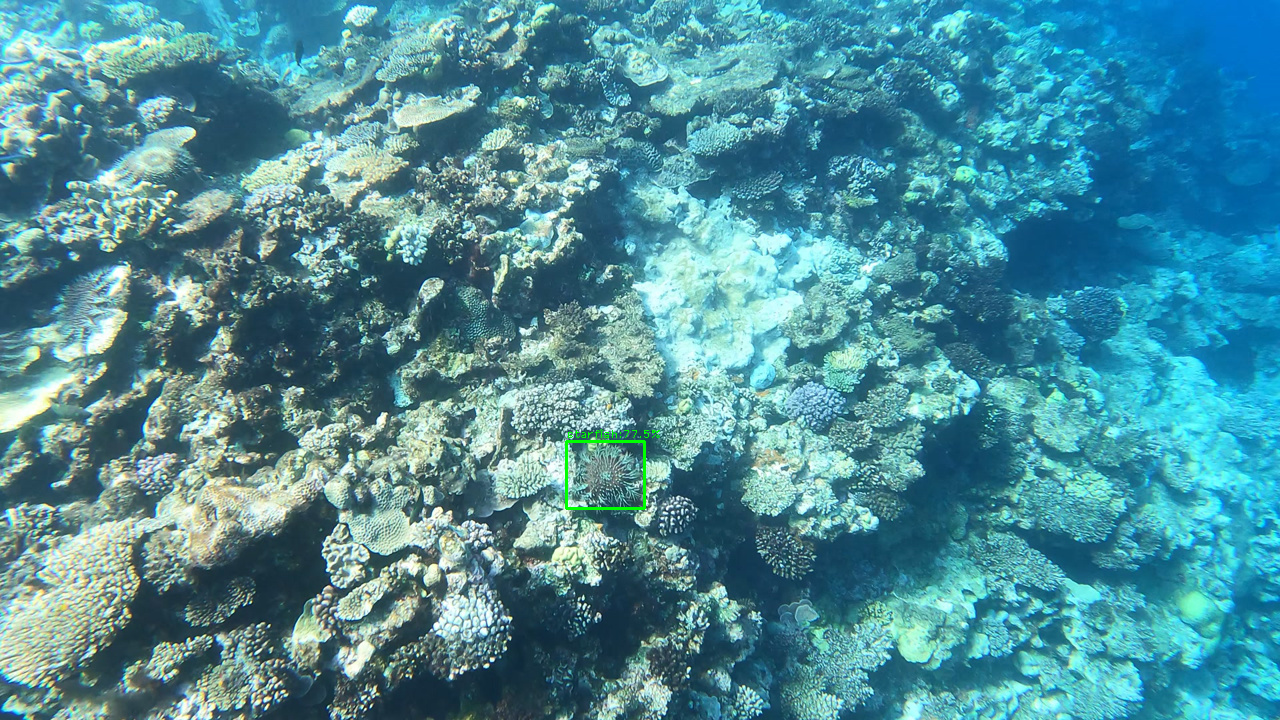

In [100]:
TEST_IMAGE_PATH = "/content/mydrive/MyDrive/kaggle/reefdata/dataset/images/val2017/0-4614.jpg"
img = cv2.imread(TEST_IMAGE_PATH)

# Get predictions
bboxes, bbclasses, scores = yolox_inference(img, model, test_size)

# Draw predictions
out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, COCO_CLASSES)

# Since we load image using OpenCV we have to convert it 
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))